# UCI SEMICOM dataset


After doing research about the dataset which can be found in the *word document* I will have put in the same folder as this analysis, I will now start to work on the dataset. I've taken a look into the dataset ( which you can also see in the sample ) and I know I have many columns with numerical variables. 

#### First we import all the important stuff and our dataset. 

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

from sklearn.feature_selection import VarianceThreshold

SemiCom = pd.read_csv("uci-secom.csv")
np.random.seed(0)

#### I will also add a function that makes sure the output is shown on full screen and not in a scrollable block.

In [64]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
return false;
}

<IPython.core.display.Javascript object>

Lets first see the size of our dataset. As we can see below we have to deal with a pretty big dataset. 
Now lets look a little closer to see what type of data we have.

In [65]:
print(SemiCom.shape)

(1567, 592)


mentions something about the nature of these columns.

***
Here we can check our data really quick.
***

In [66]:
SemiCom.sample(5)

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
319,2008-08-20 01:42:00,2926.40,2421.45,2180.9666,998.4939,1.3990,100.0,106.3311,0.1216,1.3899,...,NaN,0.5036,0.0150,0.0035,2.9800,0.0262,0.0076,0.0022,29.1606,-1
1045,2008-09-23 22:25:00,2935.34,2551.27,2276.4556,2148.5397,1.2317,100.0,93.6778,0.1199,1.4132,...,NaN,0.4941,0.0178,0.0043,3.6018,0.0257,0.0174,0.0060,67.6124,-1
1323,2008-05-10 14:34:00,3023.56,2555.88,2205.2555,1412.7131,0.9785,100.0,95.2556,0.1216,1.5407,...,NaN,0.5018,0.0127,0.0034,2.5350,0.0230,0.0210,0.0053,91.4264,-1
579,2008-08-30 11:12:00,3042.36,2493.85,2124.8444,1180.2820,0.8465,100.0,100.7978,0.1257,1.3725,...,NaN,0.4970,0.0143,0.0031,2.8703,0.0182,0.0139,0.0039,76.6094,-1
414,2008-08-22 10:47:00,2965.48,2467.94,2178.6889,1657.3518,1.6603,100.0,100.8022,0.1229,1.5611,...,43.1616,0.5008,0.0109,0.0029,2.1758,0.0433,0.0187,0.0056,43.1616,-1


### A small explanation

***
By looking at the sample and reading on kaggle about this dataset I will explain to you what this is.
This dataset is information about a machine with alot of sensors ( about 600 of them ). These sensors have an output which is always numerical or NaN. Next to that there are 
two other columns which are: Time, and pass/fail. Our goal is to predict to the best of our abilities if a row will pass or fail by using the most important features of the sensors.
***

## Cleaning the data

***
Before I can start to work with this dataset i need to clean it. The information from the dataset said we did have missing values so lets start to work on those:

* I first want to see what I'm dealing with. So I can decide if i want to remove columns or add values.
***

In [67]:
#Let's check how many rows and columns we have in this dataset
totaldata = np.product(SemiCom.shape)
totaldata

927664

In [68]:
#Total amount of missimg data
missingdata = SemiCom.isnull().sum()
totalmissingdata = missingdata.sum()
totalmissingdata 

41951

***
Now one thing i want to do is check the percentage of the total missing values in this dataset.
***

In [69]:
(totalmissingdata/totaldata) * 100

4.522219251798065

In [70]:
#I wanted to check which colums had the most NaN values
aa = missingdata.sort_values(ascending=False)

<AxesSubplot: >

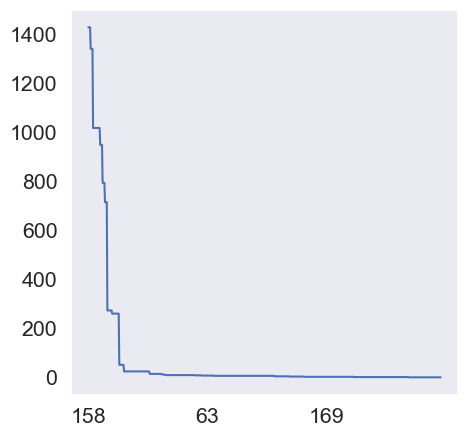

In [71]:
aa.plot()

comment: can you study where these missing values occur, are they co-occuring look like they are, can you seperate those rows, and analyze them separately. 
also you can check with the data description if there is any statemetn that may explain the missing values.

# Step 1 Cleaning: The threshold ###

***
As you can see not much of the data is missing so removing these wont have a big impact since the dataset has very many values. But, it is necessary to have a clean dataset so that our prediction is more accurate. So my plan is to make a threshold of 15%. When a column is missing more then 15% the collumn gets removed.
***

In [72]:
threshold = 0.15

columns_to_drop = missingdata[missingdata > threshold * len(SemiCom)].index
print(columns_to_drop)

Index(['72', '73', '85', '109', '110', '111', '112', '157', '158', '220',
       '244', '245', '246', '247', '292', '293', '345', '346', '358', '382',
       '383', '384', '385', '492', '516', '517', '518', '519', '546', '547',
       '548', '549', '550', '551', '552', '553', '554', '555', '556', '557',
       '562', '563', '564', '565', '566', '567', '568', '569', '578', '579',
       '580', '581'],
      dtype='object')


***
So here we can see all the columns that are above the threshold and need to be removed. My next step is dropping these columns and checking before and after if columns have been removed. I wanted to do this bit with the 'dropna()' function but this drops rows or columns based on missing values. It cannot be used to drop columns that you specify.
***

In [73]:
print(SemiCom.columns)

Index(['Time', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '581', '582', '583', '584', '585', '586', '587', '588', '589',
       'Pass/Fail'],
      dtype='object', length=592)


In [74]:
SemiCom_dropped = SemiCom.drop(columns=columns_to_drop) #Dropping the columns that have more then 15% missing values

print(SemiCom_dropped.columns)

Index(['Time', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '577', '582', '583', '584', '585', '586', '587', '588', '589',
       'Pass/Fail'],
      dtype='object', length=540)


***

As you can see our columns length has gone down from 592 to 540. Now we need look for other ways to remove columns that are useless because now we still have too many columns. 
After doing some research and asking ChatGPT how i could clean a dataset that has many numerical columns. I found the Variance threshold which means that you remove the columns that have mostly the same information. And because it's almost constantly the same it is not very usefull.

This is usefull for me because my dataset has many columns with probably the same information. Which wont provide any extra information for the model.

***

# Step 2: Variance threshold

*** 
First we have to make sure we have the types to a numerical type. 
***

In [75]:
#had a small error about the time not being able to covert to float and because time is not usefull to the model, I removed it

SemiCom_dropped= SemiCom_dropped.drop(['Time'], axis=1)


In [76]:
print(SemiCom_dropped.dtypes)

0            float64
1            float64
2            float64
3            float64
4            float64
              ...   
586          float64
587          float64
588          float64
589          float64
Pass/Fail      int64
Length: 539, dtype: object


***
I chose a variance of 0.05 because in my opinion if its beneath 0.05 it is a very minimal change and wont affect the module.
***

In [77]:

thresholder = VarianceThreshold(threshold=0.05)

X_high_variance = thresholder.fit_transform(SemiCom_dropped)
#put the remaining columns in a list
selected_features = SemiCom_dropped.columns[thresholder.get_support()].tolist()
SemiCom_filtered = SemiCom_dropped[selected_features]

SemiCom_filtered.columns

Index(['0', '1', '2', '3', '4', '6', '12', '14', '15', '16',
       ...
       '570', '571', '572', '573', '574', '576', '577', '585', '589',
       'Pass/Fail'],
      dtype='object', length=251)

***
Yep! that was a good one. We just cut our columns in half from 540 to 251.

***

# Step 3: Correlation Matrix

***
With this method we want to reduce highly correlated columns. The reason behind this is that we probably have columns that have similar information. This will help minimalize the dataset and gives us more relevant information.

I will be using a threshold of 0.8 which means that any columns with a correlation above 0.8 will be added to the list of columns that will be removed. The "For" loop compares all the columns with eachother and if the columns are highly correlated they will be put into the variable "i" and "j". all the columns in "j" will be removed.
***

In [78]:

correlation_matrix = SemiCom_filtered.corr().abs()
threshold = 0.8  #Remove columns with a correlation above 0.8

#Find columns with high correlation
highly_correlated_cols = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if correlation_matrix.iloc[i, j] > threshold:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            highly_correlated_cols.append(colname_j)

#Dropping highly correlated columns
SemiCom_correlated = SemiCom_filtered.drop(columns=highly_correlated_cols)
print(highly_correlated_cols)


['140', '275', '413', '148', '152', '154', '283', '287', '289', '420', '421', '425', '427', '36', '60', '46', '50', '66', '65', '70', '196', '197', '199', '204', '205', '207', '332', '333', '335', '336', '340', '341', '343', '469', '477', '479', '252', '390', '524', '270', '408', '271', '409', '272', '410', '273', '411', '274', '412', '275', '413', '277', '415', '152', '154', '283', '287', '289', '420', '421', '425', '427', '285', '286', '424', '154', '283', '287', '289', '420', '421', '425', '427', '283', '287', '289', '420', '421', '425', '427', '290', '428', '164', '294', '430', '295', '431', '296', '297', '165', '294', '430', '431', '434', '435', '436', '294', '430', '431', '434', '435', '436', '301', '437', '448', '316', '452', '453', '318', '454', '319', '455', '187', '321', '323', '457', '459', '321', '323', '457', '459', '324', '467', '197', '199', '203', '204', '205', '207', '332', '333', '335', '336', '340', '341', '343', '469', '471', '477', '479', '199', '204', '205', '207'

In [79]:
SemiCom_correlated.columns

Index(['0', '1', '2', '3', '4', '6', '12', '14', '15', '16',
       ...
       '539', '545', '561', '570', '571', '572', '573', '585', '589',
       'Pass/Fail'],
      dtype='object', length=138)

***
Now we're getting somewhere. We went from 251 to 138. I think this is pretty decent but I'm not completely happy with the amount of columns left. So I'm going to do some more research and find other ways to minimalize this number.
***

# Step 4: Fill Missing values

***
One of the last Cleaning steps is filling the remaining missing values. I'm doing this by filling the missing value with the mean or median. But which one is the best option for this dataset? When I searched online I found out that mean is often used when the distribution is pretty symmetric in this case median can also be used. The difference wont be big. When the distribution is skewed the mean is not useful. The median is less sensitive to outliers.

So our first step is seeing what distribution this dataset has.
***

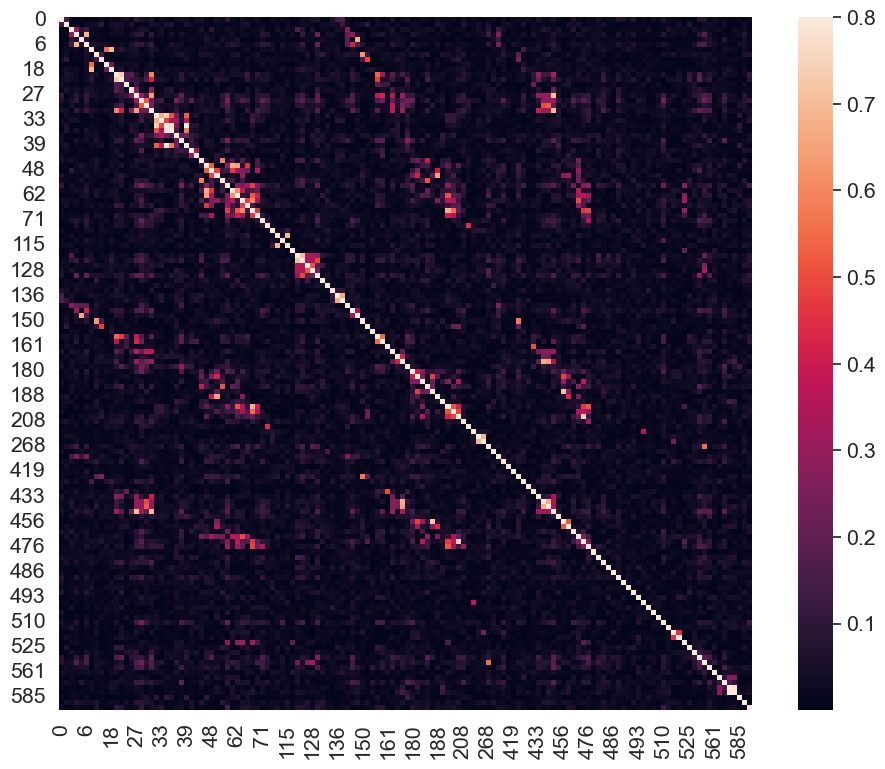

In [80]:
correlationmat = SemiCom_correlated.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(np.abs(correlationmat), vmax=.8, square=True);


is target here or not. make it clear!

[optional] Try out Hierarchical clustering and find similar columns, maybe also useful for missing values

***
Let's look at the skewness of our dataset.
***

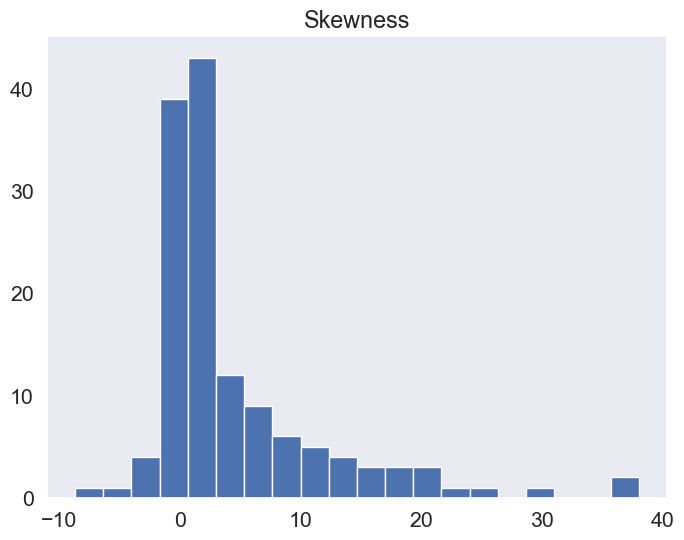

In [81]:
skewness = SemiCom_correlated.skew()

plt.figure(figsize=(8, 6))
plt.hist(skewness, bins=20)
plt.title('Skewness')
plt.show()

the tail values are important to identify , maybe you want to remove these or note any pattern, later if you build a model, you can check if it works on these points

***
So from the graph above we can mke the conclusion that we're dealing with a skewed distribution. And from our research we now know we need to use the "Mean" to fill/Impude the remaining missing values.
***

In [82]:
missingvalues = SemiCom_correlated.isnull().sum()
print(missingvalues.sum())
print(missingvalues.shape)

886
(138,)


In [83]:
SemiCom_correlated = SemiCom_correlated.fillna(SemiCom_correlated.mean())
missingdata = SemiCom_correlated.isnull().sum()
totalmissingdata = missingdata.sum()
print(totalmissingdata)
print(missingdata.shape)

0
(138,)


build a base line early, 

# Step 5: Handling outliers - Is this a good method for my dataset?

***

To clean my dataset some more my next step was to get rid of the outliers. But when i started removing the outliers 1/3 of my dataset went away. So I'm not too sure about handling the outliers

In [84]:
missing_values = SemiCom_correlated.isnull().sum()
print(missing_values)

0            0
1            0
2            0
3            0
4            0
            ..
572          0
573          0
585          0
589          0
Pass/Fail    0
Length: 138, dtype: int64


optional: after modeling you can look into regions where the error is large, by selecting points with large prediction error, and compare the statisitcs of the features for those points with the the rest of the points. for example side to side bar plots for each feature. make a plot of the difference of the mean or median

beacuae you have too many features, maybe you can group columns via hierarchical clustering and then analyze in the group.

consider the model you want to use, does this model need scaling?


calculate the correlation of all features with the target and make a bar plot, and find highly occrelating features, for those make a scatter plot. 
calculate the mutual information  of all features with the target and make a bar plot, and find highly occrelating features, for those make a scatter plot. 

goal is to predict ==. strategy is what is informaing us about the target

compare performance as you inisitall planned. histograms.
compare the count of each class, establish if it is imbalanced.

<AxesSubplot: >

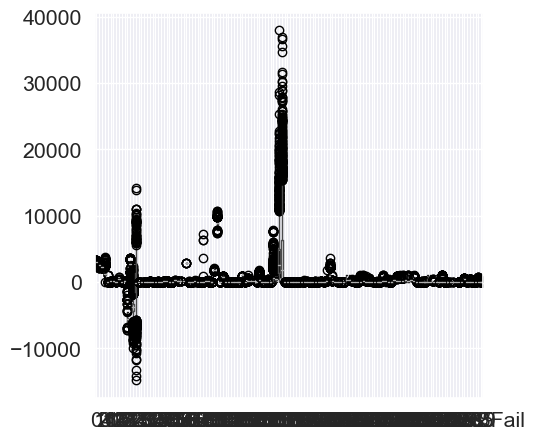

In [85]:
SemiCom_correlated.boxplot()

In [86]:
threshold_percentile = 99  


for column in SemiCom_correlated.columns:
    threshold = np.percentile(SemiCom_correlated[column], threshold_percentile)
    SemiCom_correlated.loc[SemiCom_correlated[column] > threshold, column] = np.nan
df_cleaned = SemiCom_correlated.dropna()


<AxesSubplot: >

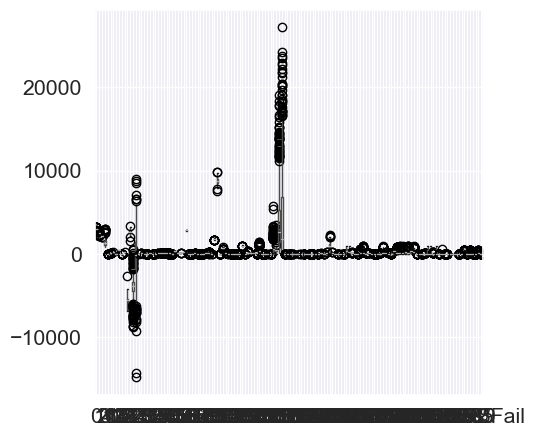

In [87]:
df_cleaned.boxplot()

In [88]:
print(df_cleaned.shape)
print(SemiCom_correlated.shape)


(511, 138)
(1567, 138)


In [89]:
SemiCom_correlated = SemiCom_correlated.fillna(SemiCom_correlated.mean())
missing_values = SemiCom_correlated.isnull().sum()
print(missing_values)

0            0
1            0
2            0
3            0
4            0
            ..
572          0
573          0
585          0
589          0
Pass/Fail    0
Length: 138, dtype: int64


***
Now we look at the accuracy of our Dataset when it is not cleared from outliers, and then we look at the accuracy of the dataset that will be cleaned of outliers. With this we can conclude if we need to remove outliers. And if not there is a big question in why there are so many outliers.
***

### Uncleaned from outliers

In [90]:

X = SemiCom_correlated.drop(columns=['Pass/Fail'])
y = SemiCom_correlated['Pass/Fail']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(solver='sag', max_iter=6000)
model.fit(X_train, y_train)

# Make predictions on the original test set
y_pred_original = model.predict(X_test)
print("Accuracy: ", model.score(X_test,y_test)*100)

Accuracy:  91.71974522292994


***
here we split the dataset into train and test. now we have an accuracy but lets look at the correlation matrix.
***

In [91]:
lr = LogisticRegression(random_state=1, max_iter=6000, solver='sag')
lr.fit(X_train, y_train) 
y_pred = lr.predict(X_test)

[[288   2]
 [ 24   0]]


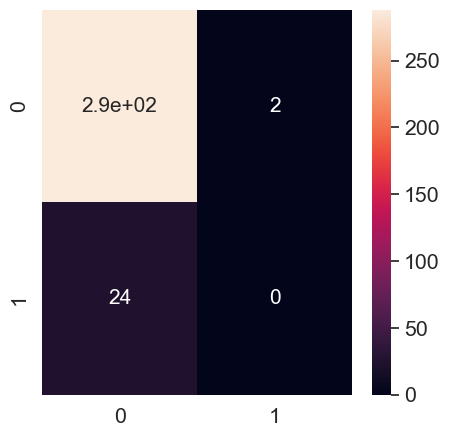

In [92]:
cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})
print(cm)


***
To summarize:

- True Positives (TP): 288
- False Positives (FP): 2
- False Negatives (FN): 24
- True Negatives (TN): 0
***

In [93]:
print("Accuracy: ", lr.score(X_test,y_test)*100)

Accuracy:  91.71974522292994


### Cleaned from outliers

In [94]:
# same thing here as above but now with the outliers dropped.
X = df_cleaned.drop(columns=['Pass/Fail'])
y = df_cleaned['Pass/Fail']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(solver='sag', max_iter=8000)

model.fit(X_train, y_train)

y_pred_original = model.predict(X_test)
print("Accuracy: ", model.score(X_test,y_test)*100)

Accuracy:  90.29126213592234


[[93  1]
 [ 9  0]]


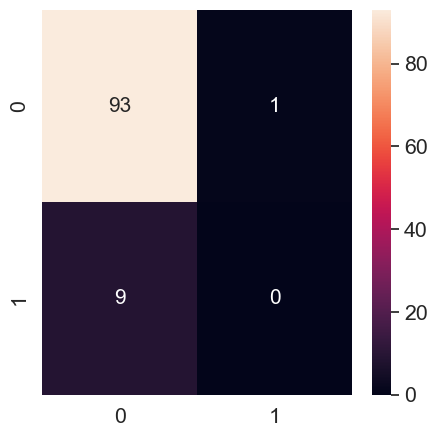

In [95]:
lr = LogisticRegression(random_state=1, solver='sag', max_iter=8000)
lr.fit(X_train, y_train) 
y_pred = lr.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

print(cm)

***
To summarize:

- True Positives (TP): 92
- False Positives (FP): 2
- False Negatives (FN): 9
- True Negatives (TN): 0
***

## Conclusion:

The confusion matrix can calculate 3 things for us:

- Accuracy -> correct predictions/ total number of predictions
- Precision -> TN / (TP + FP)
- Recall -> TP / (FP + FN)

When i calculate these for both confusion matrixes this is the outcome:

Without outliers:

A : 90.19%
P : 97.87%
R : 91.09%

With outliers

A : 91.89%
P : 99.31%
R : 92.31%


This shows that the performance and accuracy with outliers is higher then the one without outliers. So in conclusion we will not be removing outliers.


# Step 6: hierarchical clustering

-
-
-


# Step 7: Oversampler / Undersampler

from working on another problem I came to this usefull method that is very helpful for this dataset. Let me explain why.

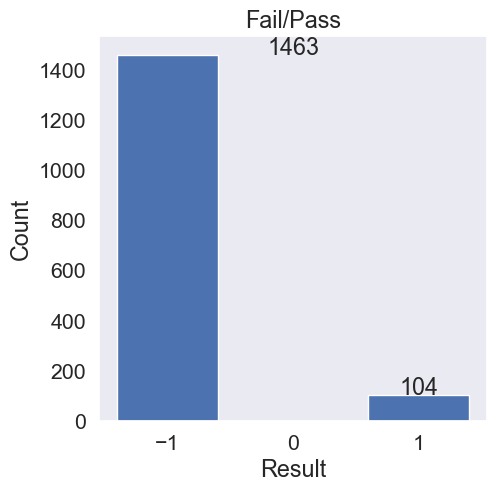

In [96]:
value_counts = SemiCom_correlated['Pass/Fail'].value_counts()

plt.bar(value_counts.index, value_counts.values)
#show amount of 0,1
for i, count in enumerate(value_counts.values):
    plt.text(i, count + 0.5, str(count), ha='center')

plt.xlabel('Result')
plt.ylabel('Count')
plt.title('Fail/Pass')

plt.show()

***
The difference in pass and fail is huge. Which is why our model never guesses the "negative". A solution to this problem is using the oversampler. With this we can equallize the amount of the sample when it comes to pass and fail. Then the model should be able to predict better then now. So let's test that out.
***

### Let's test if this is usefull for our model

In [97]:

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, accuracy_score

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

### Oversampled results: Precision, recall, accuracy
***

              precision    recall  f1-score   support

        -1.0       0.93      0.73      0.82        94
         1.0       0.14      0.44      0.21         9

    accuracy                           0.71       103
   macro avg       0.54      0.59      0.52       103
weighted avg       0.86      0.71      0.77       103

[[69 25]
 [ 5  4]]


<AxesSubplot: >

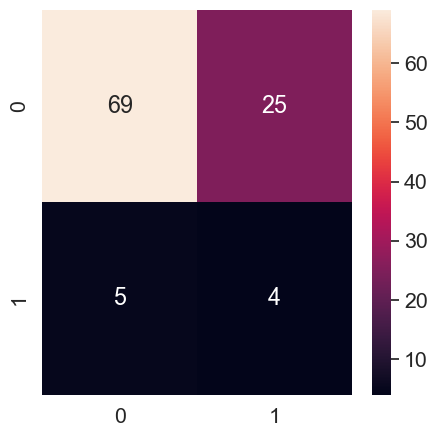

In [98]:
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

classifier = LogisticRegression(solver='sag', max_iter=9000)
classifier.fit(X_train_resampled, y_train_resampled)
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

cm_oversampled = confusion_matrix(y_test, y_pred)

print(cm_oversampled)
sns.heatmap(cm_oversampled, annot=True)

***

The reason we're using this is to look at the difference between the majority class (pass) and the minority class (fail). As we can see the minority is pretty bad. There is a majority in fale negatives.
Now we are going to equalize the samples to hopefully change the performance.
***

### Undersampler: Creating equal samples to test this theorie
***

              precision    recall  f1-score   support

        -1.0       0.96      0.92      0.94        25
         1.0       0.92      0.96      0.94        25

    accuracy                           0.94        50
   macro avg       0.94      0.94      0.94        50
weighted avg       0.94      0.94      0.94        50



<AxesSubplot: >

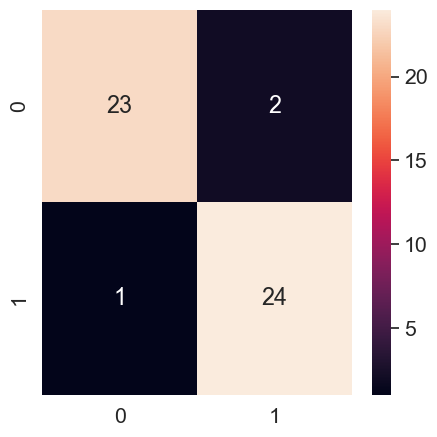

In [110]:
rus = RandomUnderSampler(random_state=42)

X_train_under_sampled, y_train_under_sampled = rus.fit_resample(X_train, y_train)

classifier.fit(X_train_under_sampled, y_train_under_sampled)

y_pred = classifier.predict(X_train_under_sampled)
print(classification_report(y_train_under_sampled, y_pred))
cm_equal = confusion_matrix(y_train_under_sampled, y_pred)
sns.heatmap(cm_equal, annot=True)

### This one is undersampled: (Equalized)
***

*** 



## Sample_Stategy added

              precision    recall  f1-score   support

        -1.0       0.86      0.96      0.91        50
         1.0       0.89      0.68      0.77        25

    accuracy                           0.87        75
   macro avg       0.88      0.82      0.84        75
weighted avg       0.87      0.87      0.86        75



<AxesSubplot: >

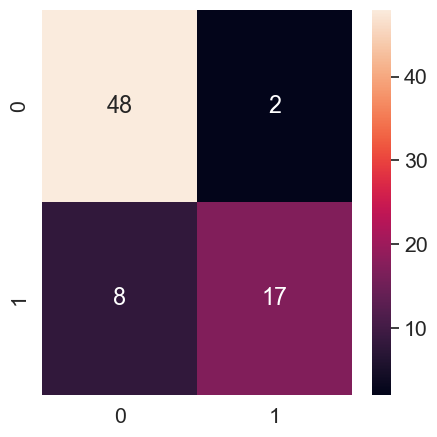

In [111]:
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)

X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)

classifier.fit(X_train_undersampled, y_train_undersampled)

y_pred = classifier.predict(X_train_undersampled)
print(classification_report(y_train_undersampled, y_pred))

y_pred = classifier.predict(X_train_undersampled)
cm_unequal_undersampler = confusion_matrix(y_train_undersampled, y_pred)
sns.heatmap(cm_unequal_undersampler, annot=True)

In [101]:
print(cm_oversampled)

[[69 25]
 [ 5  4]]


In [102]:
print(cm_equal)

[[23  2]
 [ 1 24]]


In [103]:
print(cm_unequal_undersampler)

[[48  2]
 [ 8 17]]


***
This is pretty good because in our dataset false negatives are relatively better then false positives. because a fail that actually passed is better then the other way around. from the undersampled options I like the equally sampled one the most. this one has the least false negatives and positives aswell. Next to that when looking at the performance the equal undersampler has the highest score in all aspects.
***

# GridSearch

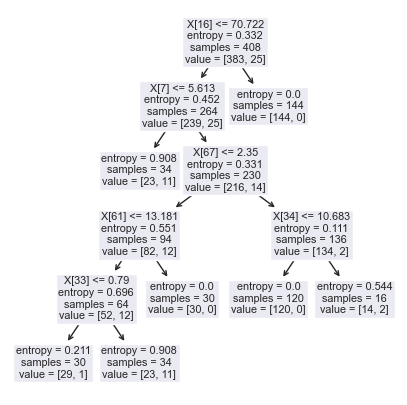

{'criterion': 'entropy', 'min_samples_leaf': 4, 'min_samples_split': 54}
0.9387232761216501


In [104]:
from sklearn.tree import plot_tree
# Define the parameter grid
param_grid =  {    'criterion': ['gini', 'entropy'],
    'min_samples_split': [25, 30, 40, 50,54,53,52,55,56,57,60, 70, 80],
    'min_samples_leaf': [1, 2, 3, 4 , 5 ,],}   
# Create a decision tree classifier
model = DecisionTreeClassifier()

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameter and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_

plot_tree(best_model)
plt.show()

print(best_params)
print(best_score)

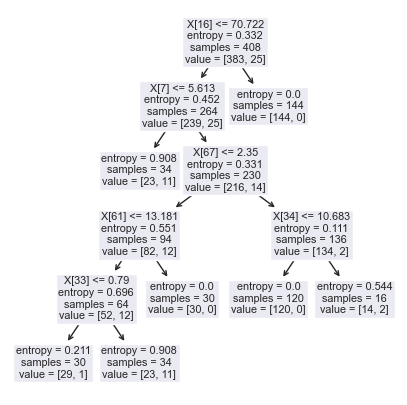

In [105]:
from sklearn.tree import plot_tree


best_model = grid_search.best_estimator_

plot_tree(best_model)
plt.show()

## Undersampled? -> equal

In [112]:
# Define the parameter grid
param_grid =  {    'criterion': ['gini', 'entropy'],
    'min_samples_split': [5, 10 ,20,21, 22, 23 ,25, 30, 40, 50],
    'min_samples_leaf': [1, 2, 3, 4 , 5 ,],}   
# Create a decision tree classifier
model = DecisionTreeClassifier()

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X_train_undersampled, y_train_undersampled)

# Get the best parameter and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(best_params)
print(best_score)

{'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 40}
0.7066666666666668


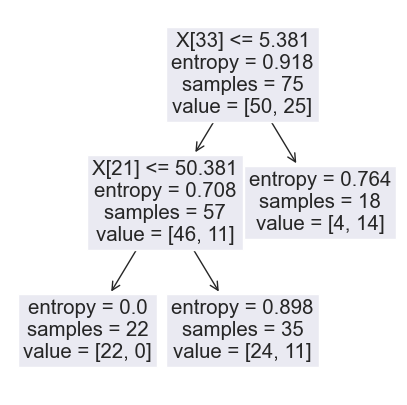

In [113]:
best_model = grid_search.best_estimator_

plot_tree(best_model)
plt.show()

# Grid search for the Unequal undersample

In [114]:
# Define the parameter grid
param_grid =  {    'criterion': ['gini', 'entropy'],
    'min_samples_split': [5, 10 ,20,21, 22, 23 ,25, 30, 40, 50],
    'min_samples_leaf': [1, 2, 3, 4 , 5 ,],}   
# Create a decision tree classifier
model = DecisionTreeClassifier()

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X_train_under_sampled, y_train_under_sampled)

# Get the best parameter and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(best_params)
print(best_score)

{'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 5}
0.6


## Evaluation: grid search

???? 

why is the accuracy not the same? this is one thing i was very confused about so i started to look it up. Here is a small explanation why:

Data imbalance: Undersampling the majority class can lead to a more balanced training set, which may improve the accuracy on the undersampled training set. However, it does not guarantee better performance on the original imbalanced dataset or unseen data.

Grid search aims to find the best hyperparameters that generalize well to unseen data, while the accuracy on the undersampled training set only reflects performance on the training data itself.